#### **To install rdkit**
##### conda install -c rdkit rdkit
##### pip install jupyterlab

In [1]:
import os
import pandas as pd

#### **Load Pre-Processed data from Part-1**

In [2]:
df = pd.read_csv ("bioactivity_preprocessed_data.csv")

### **Lipinskis rule of 5 :**
##### Christopher Lipinski, a Scientist at Pfizer, came up with a set of rule of thumb for evalutaing the **drug likeness** of compunds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion **(ADME)** that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule of Five, or Lipinski's Rule.
##### **1.** Weight of 1 Molecule should be less than 500gm/mole
##### **2.** log (P) < 5
P -> The Octanol : Water Partition coefficient
If all the drug goes into octanol, then the ratio of Octanol will be very large, then it will be soluble, but it cannot be taken in the blood stream.
In other words, it can't be too hydrophobic.
##### **3.** Less than 5 H-bond donors (-OH)
##### **4.** Less than 10 H-bond acceptors (-O)
If there are too many hydrogen bond donors and acceptors, then the molecule will be very hydrophilic, and will be very soluble in blood, but it will not be able to go through the blood-brain barrier. Also, most of the binding sites for the drug will be hydrophobic.
So, it can't be too hydrophobic, it can't be too hydrophilic.

In [3]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

#### **Compute Descriptors**
##### We'll use the inbuilt function in rdkit Descriptors to find the values for the Lipinski Descriptors from the Canonical Smiles

In [4]:
def get_lipinski_descriptors (canonical_smiles) :
    molecules = []
    for canonical_smile in canonical_smiles :
        molecule = Chem.MolFromSmiles (canonical_smile) 
        molecules.append (molecule)
       
    descriptors = []
    for molecule in molecules :
        descriptors_MolWt = Descriptors.MolWt (molecule)
        descriptors_MolLogP = Descriptors.MolLogP (molecule)
        descriptors_NumHDonors = Lipinski.NumHDonors (molecule)
        descriptors_NumHAcceptors = Lipinski.NumHAcceptors (molecule)
           
        row = np.array ([descriptors_MolWt, descriptors_MolLogP, descriptors_NumHDonors, descriptors_NumHAcceptors])
        descriptors.append (row)
    
    column_names = ["MolecularWeight", "LogP", "NumHDonors", "NumHAcceptors"]   
    descriptors = pd.DataFrame (data = descriptors, columns = column_names)
    
    return descriptors

In [5]:
df_lipinski = get_lipinski_descriptors (df.values [:, 1])
df_lipinski

,MolecularWeight,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [6]:
df_combined = pd.concat ([df, df_lipinski], axis = 1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MolecularWeight,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


#### **Conversion of IC50 values into PIC 50 values**
**`PIC50 = - log10 (IC50)`**
1. This is being done for the IC50 values to be more uniformly distributed.
2. The IC50 values are contained in the standard value column, and they are in nM (nano Molar Unit).  
3. We'll multiply them with 10^9 to convert them to Molar (from nano Molar).  
4. Then, we'll find the -log10 to convert the IC50 values into PIC50.  

In [7]:
df_combined.standard_value.describe ()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

#### Step 1 : Cap the values to 100000000

In [8]:
standard_values_capped = []
for standard_value in df_combined.values [:, 2] :
    if standard_value > 100000000 :
        standard_values_capped.append (100000000)
    
    else :
        standard_values_capped.append (standard_value)
        
df_combined ['standard_value_capped'] = standard_values_capped
df_capped = df_combined.drop ('standard_value', axis = 1)
df_capped.standard_value_capped.describe ()
df_capped

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolecularWeight,LogP,NumHDonors,NumHAcceptors,standard_value_capped
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


#### Step 2 : Convert IC50 values to PIC50

In [9]:
# Convert from nM (nano Molar) to Molar by multiplying by 10^-9
df_capped.standard_value_capped = df_capped.standard_value_capped * 1e-9

#### **Convert from IC50 to PIC50 using :**
**`PIC50 = - log10 (IC50)`**

In [10]:
df_capped_PIC50 = df_capped.copy ()
df_capped_PIC50 = df_capped_PIC50.rename (columns = {"standard_value_capped": "PIC50"})
df_capped_PIC50.PIC50 = -np.log10 (df_capped_PIC50.PIC50.values)

In [11]:
print (df_capped_PIC50.head (5))
print (df_capped.head (5))

  molecule_chembl_id                                 canonical_smiles  \
0       CHEMBL187579           Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21   
1       CHEMBL188487           O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21   
2       CHEMBL185698          O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21   
3       CHEMBL426082              O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21   
4       CHEMBL187717  O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]   

  bioactivity_class  MolecularWeight     LogP  NumHDonors  NumHAcceptors  \
0      intermediate          281.271  1.89262         0.0            5.0   
1      intermediate          415.589  3.81320         0.0            2.0   
2          inactive          421.190  2.66050         0.0            4.0   
3          inactive          293.347  3.63080         0.0            3.0   
4      intermediate          338.344  3.53900         0.0            5.0   

      PIC50  
0  5.142668  
1  5.026872  
2  4.869666  
3  4.882397  
4  5.698970  
  molecule_chembl_id

In [12]:
print (df_capped.standard_value_capped.describe ())
print (df_capped_PIC50.PIC50.describe ())

count    1.330000e+02
mean     2.110164e-02
std      4.089714e-02
min      5.000000e-08
25%      1.070000e-05
50%      2.350000e-05
75%      3.000000e-04
max      1.000000e-01
Name: standard_value_capped, dtype: float64
count    133.000000
mean       4.060148
std        1.783762
min        1.000000
25%        3.522879
50%        4.628932
75%        4.970616
max        7.301030
Name: PIC50, dtype: float64


#### **Remove the intermediate Bio-Activity class from the dataset**
##### This is being done to get a simple comparison between the two Bio-Activity classes

In [15]:
df_two_class = df_capped_PIC50 [df_capped_PIC50.bioactivity_class != 'intermediate']
df_two_class.to_csv ("bioactivity_two_class_pic50.csv")
df_two_class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolecularWeight,LogP,NumHDonors,NumHAcceptors,PIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


#### **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

##### **Import Libraries**

import seaborn as sns
sns.set (style = 'ticks')
import matplotlib.pyplot as plt

#### **Frequency plots for bioactivity class**

Text(0, 0.5, 'Frequency')

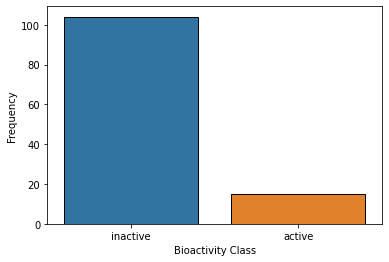

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot (x = 'bioactivity_class', data = df_two_class, edgecolor = 'black')
plt.xlabel ("Bioactivity Class")
plt.ylabel ("Frequency")

#### **Scatter plot of Molecular Weight vs. Log (P)**

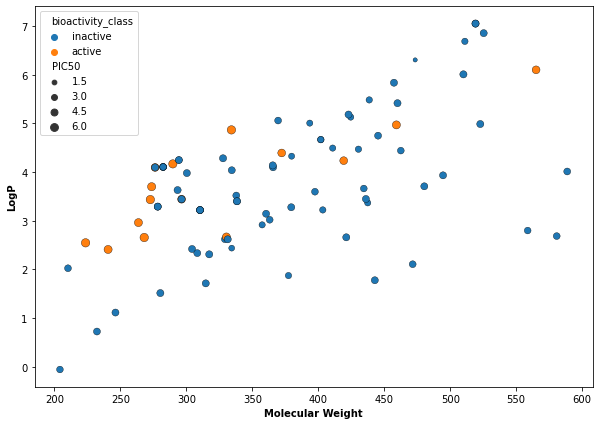

In [15]:
plt.figure (figsize = (10, 7))
sns.scatterplot (x = 'MolecularWeight',
                 y = 'LogP', hue = 'bioactivity_class',
                 data = df_two_class,
                 size = 'PIC50',
                 edgecolor = 'black')

plt.xlabel ("Molecular Weight", fontweight = 'bold')
plt.ylabel ("LogP", fontweight = 'bold')
plt.savefig (os.path.join ("Observations", "Scatter_Mol_Wt_vs_LogP.pdf"))

#### **Box Plots**

##### **Bioactivity Class vs. PIC50**

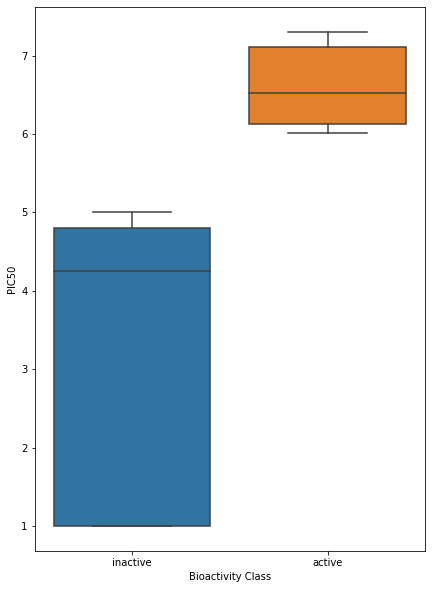

In [16]:
plt.figure (figsize = (7, 10))
sns.boxplot (x = 'bioactivity_class', y = 'PIC50', data = df_two_class)
plt.xlabel ('Bioactivity Class')
plt.ylabel ('PIC50')
plt.savefig (os.path.join ("Observations", "Box_Bioactivity_vs_PIC50.pdf"))

#### **Statistical Analysis - Matt Whitney U Test**

##### **"Statistical Significance"** refers to the probability that the observed result could have occurred randomly if it has no true underlying effect. ... If you run statistical tests on questions that are likely to be true, your findings are less likely to be false.
##### **Source :** https://www.nngroup.com/articles/understanding-statistical-significance/
##### **In other words, if a result exists in the sample, then we have evidence that it also exists in the population**
##### **We can use p-value to find statistical significance**

In [33]:
def mann_whitney (descriptor) :
    from numpy.random import seed, randn
    from scipy.stats import mannwhitneyu
    
    # Seed the Random Number Generator
    seed (1)
    
    # Actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_two_class [selection]
    active = df [df.bioactivity_class == 'active']
    active = active [descriptor]
    
    selection = [descriptor, 'bioactivity_class']
    df = df_two_class [selection]
    inactive = df [df.bioactivity_class == 'inactive']
    inactive = inactive [descriptor]
    
    stat, p = mannwhitneyu (active, inactive)
    
    alpha = 0.05
    if p > alpha :
        interpretation = 'Same distribution (fail to reject H0)'
    else :
        interpretation = 'Different distribution (reject H0)'
        
    results = pd.DataFrame ({'Descriptor' : descriptor,
                             'Statistics' : stat,
                             'p' : p,
                             'alpha' : alpha,
                             'Interpretation' : interpretation}, index = [0])
    
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv (filename)
    return results

In [38]:
mann_whitney ('PIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,PIC50,1560.0,3.325272e-10,0.05,Different distribution (reject H0)


#### **Molecular Weight**

<AxesSubplot:xlabel='bioactivity_class', ylabel='MolecularWeight'>

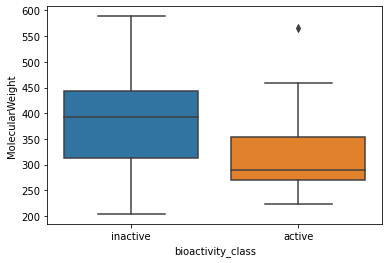

In [40]:
sns.boxplot (x = 'bioactivity_class',
             y = 'MolecularWeight',
             data = df_two_class)

In [41]:
mann_whitney ("MolecularWeight")

,Descriptor,Statistics,p,alpha,Interpretation
0,MolecularWeight,409.5,0.003049,0.05,Different distribution (reject H0)


#### **LogP**

<AxesSubplot:xlabel='bioactivity_class', ylabel='LogP'>

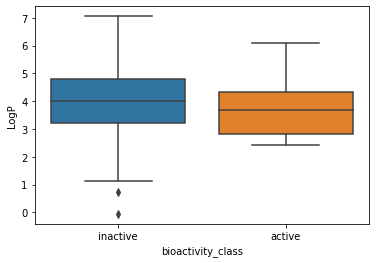

In [42]:
sns.boxplot (x = 'bioactivity_class',
             y = 'LogP',
             data = df_two_class)

In [44]:
mann_whitney ('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.591609,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

<AxesSubplot:xlabel='bioactivity_class', ylabel='NumHDonors'>

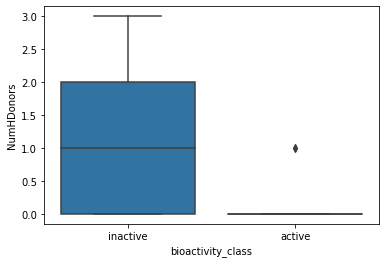

In [45]:
sns.boxplot (x = 'bioactivity_class', y = 'NumHDonors', data = df_two_class)

#### **Mann Whitney U - Test**

In [46]:
mann_whitney ('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000049,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

<AxesSubplot:xlabel='bioactivity_class', ylabel='NumHAcceptors'>

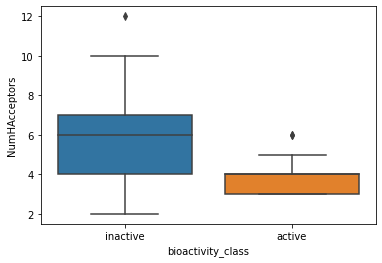

In [47]:
sns.boxplot (x = 'bioactivity_class', y = 'NumHAcceptors', data = df_two_class)

In [50]:
mann_whitney ('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.003115,0.05,Different distribution (reject H0)
